# E0424649 Foh Cher Ern Don Assignment 3

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from scipy.stats import f_oneway

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

import seaborn as sns
import matplotlib.pyplot as plt


# Introduction
Upon rough examination of the data, I felt that the total amount of revenue earned wouuld be interesting to model and predict. As such, I decided to use that as my target variable and explored 3 different approaches to modelling it.

In [2]:
# Loading in data
rosewood = pd.read_csv("HotelRosewood.csv")

# Irrelevant features to drop: ID, NameHash, DocIDHash
rosewood_clean = rosewood.drop(columns=["ID", "NameHash", "DocIDHash"])

# Create "TotalRevenue" column to use as target variable
rosewood_clean["TotalRevenue"] = rosewood_clean["LodgingRevenue"] + rosewood_clean["OtherRevenue"]
rosewood_clean = rosewood_clean.drop(columns=["OtherRevenue", "LodgingRevenue"])


# EDA

### Preliminary EDA - Understanding "SR" columns
There are multiple columns pre-fixed with "SR". At first glance, these columns appear to be dummy variables for categorical variables, as some coluumns seemed to be related to one another ("SRKingSizeBed", "SRCrib", "SRTwinBed"). I thus decided to explore these variables to better understand what exactly they represent.

In [3]:
# Checking if all SR variables are dummy variables for one big category
print("Unique values for sum: ", rosewood_clean.loc[:, rosewood_clean.columns.str.contains("SR")].sum(axis=1).unique())

Unique values for sum:  [1 0 2 3 4]


In [4]:
# Checking if seemingly related SR variables are dummy variables for a category
# Checking for "SRKingSizeBed", "SRCrib", "SRTwinBed"
print("Unique values for sum: ", rosewood_clean[["SRKingSizeBed", "SRCrib", "SRTwinBed"]].sum(axis=1).unique())

Unique values for sum:  [1 0 2 3]


Since the sum of all SR columns is greater than 1 for certain rows, I concluded that all SR columns are not dummy variables for one big category.
<br>
<br>
Similarly, since the sum of SRKingSizeBed, SRCrib, and SRTwinBed (seemingly related variables) is greater than 1 for certain rows, I also concluded that seemingly related columns are not dummy variables for a categorical variable as well.
<br>
<br>
To explain this, I assumed that SR stands for "Special Request", and is used to indicate if customers make certain special requests for their room bookings. Hence, since customers are not constrained to ensuring their requests must be mutually exclusive from others (i.e those who request for a king bed can still request for a twin bed), the variables do not necessarily have to add up to 1.
<br>
<br>
As such, I treated each SR variable as its own indicator variable. 

### Checking categorical variables

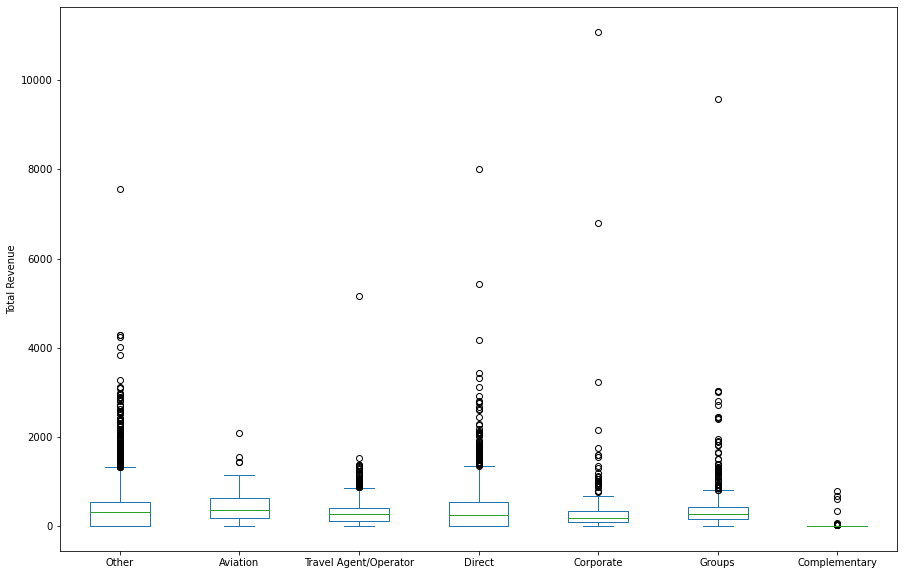

In [5]:
ms = {}

for segment in rosewood_clean["MarketSegment"].unique():
    ms[segment] = rosewood_clean[rosewood_clean["MarketSegment"] == segment]["TotalRevenue"]
    
pd.DataFrame(ms).plot.box(figsize=(15,10))
plt.ylabel("Total Revenue")
plt.show()

In [6]:
# ANOVA test
f_oneway(*list(ms.values()))

F_onewayResult(statistic=13.470959996872622, pvalue=2.7942209810980077e-15)

It seems like the median for different market segments are roughly similar. However, the distribution varies widely, and certain segments such as "Corporate" have a highly skewed distribution. Hence, certain segments are likely to be statistically significantly different from one another. This is supported by the oneway ANOVA as the p-value indicates the difference between different market segments is statistically significant.
<br>
<br>
Hence, MarketSegment may be useful in predicting TotalRevenue.

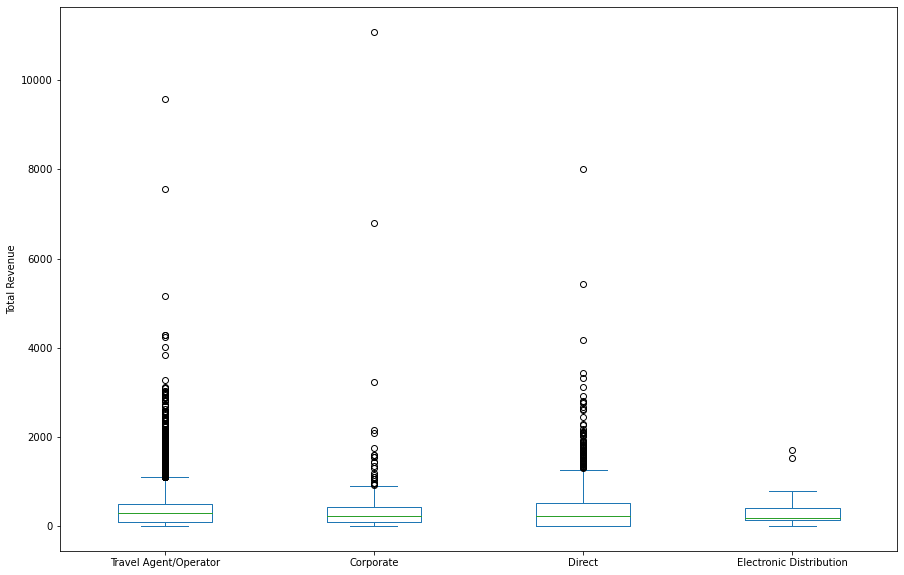

In [7]:
dc = {}

for channel in rosewood_clean["DistributionChannel"].unique():
    dc[channel] = rosewood_clean[rosewood_clean["DistributionChannel"] == channel]["TotalRevenue"]
    
pd.DataFrame(dc).plot.box(figsize=(15,10))
plt.ylabel("Total Revenue")

plt.show()

In [8]:
f_oneway(*list(dc.values()))

F_onewayResult(statistic=1.1899033132419927, pvalue=0.31189091592167384)

The medians of the different distribution channels  appear to be similar. Moreover, the distribution of 2 "Travel Agent/Operator" and "Direct" appear quite similar. Moreover, the ANOVA test has a fairly large p-value. Hence, DistributionChannel may not be useful in predicting TotalRevenue.

### Distribution of TotalRevenue

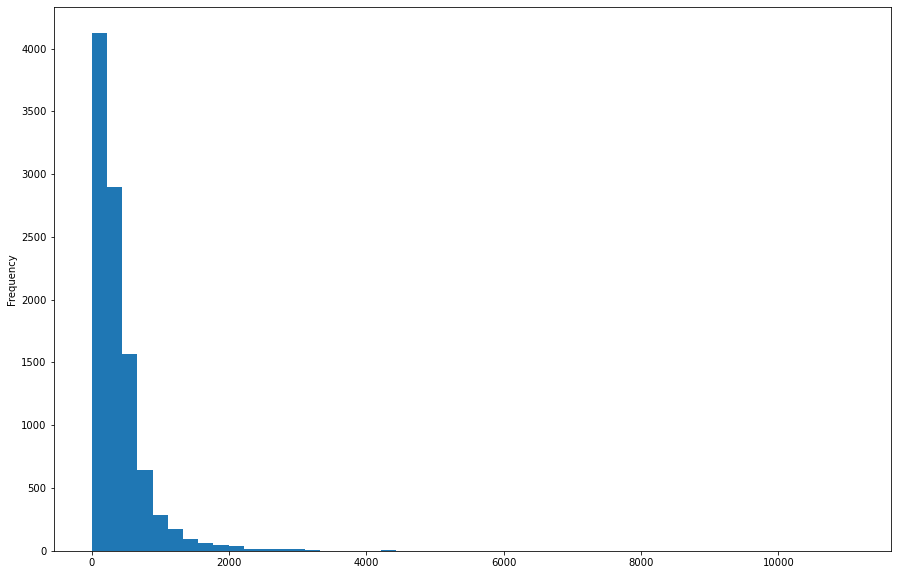

In [9]:
rosewood_clean["TotalRevenue"].plot.hist(bins=50, figsize=(15,10))
plt.show()

In [10]:
(rosewood_clean["TotalRevenue"] == 0).mean()

0.2354

This distribution of the target variable TotalRevenue appears to be quite skewed, with a large proportion of values being 0.

### Correlation heatmap

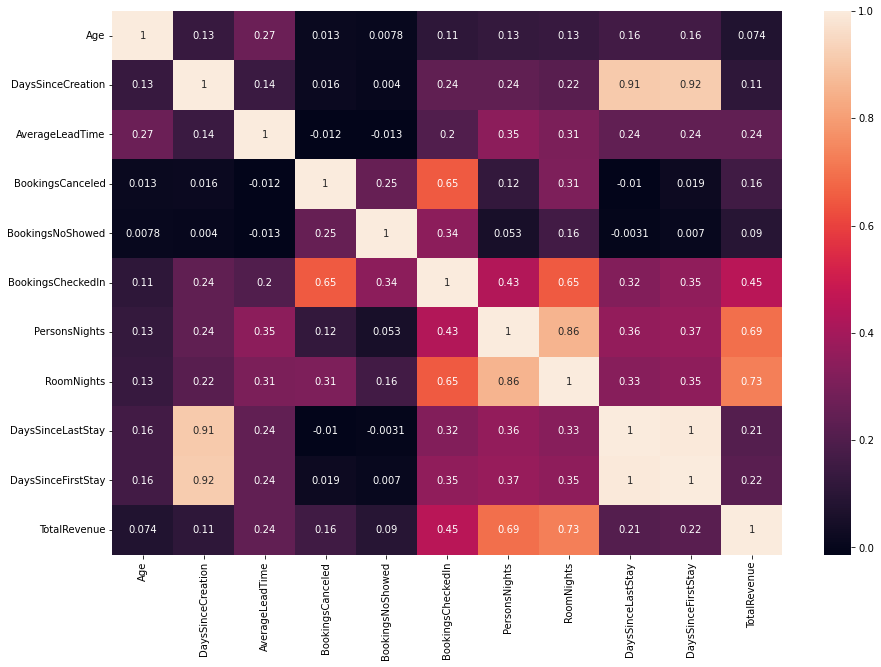

In [11]:
# Correlation heatmap
categorical_variables = ["MarketSegment", "DistributionChannel"]
indicator_variables = rosewood_clean.columns[rosewood_clean.columns.str.contains("SR")]

plt.figure(figsize=(15,10))
sns.heatmap(rosewood_clean.drop(columns=indicator_variables).drop(columns=categorical_variables).corr(), annot=True)
plt.show()

DaysSinceLastStay and DaysSinceFirstStay are perfectly correlated. This makes intuitive sense as one is a linear function of the other (DaysSinceFirstStay = DaysSinceLastStay + Days between first and last stay)
<br>
<br>
Similarly, DaysSinceLastStay and DaysSinceFirstStay are both highly correlated with DaysSinceCreation.
<br>
<br>
RoomNights and PersonNights are both also highly correlated.
<br>
<br>
The features which are most correlated with TotalRevenue are RoomNights and PersonsNights, indicating they are likely to be useful predictors. However, as mentioned, RoomNights and PersonsNights are highly correlated. This should be noted down as it could potentially cause multicollinearity.

# Data preprocessing

In [12]:
# Create dummies for "MarketSegment" and "DistributionChannel"

categorical_variables = ["MarketSegment", "DistributionChannel"]
rosewood_dummies = pd.get_dummies(rosewood_clean[categorical_variables], drop_first=True)
rosewood_clean = rosewood_clean.join(rosewood_dummies).drop(columns=categorical_variables)

In [13]:
rosewood_clean.isna().sum()

Age                                            463
DaysSinceCreation                                0
AverageLeadTime                                  0
BookingsCanceled                                 0
BookingsNoShowed                                 0
BookingsCheckedIn                                0
PersonsNights                                    0
RoomNights                                       0
DaysSinceLastStay                                0
DaysSinceFirstStay                               0
SRHighFloor                                      0
SRLowFloor                                       0
SRAccessibleRoom                                 0
SRMediumFloor                                    0
SRBathtub                                        0
SRShower                                         0
SRCrib                                           0
SRKingSizeBed                                    0
SRTwinBed                                        0
SRNearElevator                 

In [14]:
# Set missing values as mean, with indicator to show that they're missing
rosewood_clean["AgeMissing"] = 0
rosewood_clean.loc[rosewood_clean["Age"].isna(), "AgeMissing"] = 1
rosewood_clean.loc[rosewood_clean["Age"].isna(), "Age"] = rosewood_clean["Age"].mean()

In [15]:
rosewood_clean.head()

,Age,DaysSinceCreation,AverageLeadTime,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,...,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Other,MarketSegment_Travel Agent/Operator,DistributionChannel_Direct,DistributionChannel_Electronic Distribution,DistributionChannel_Travel Agent/Operator,AgeMissing
0,35.0,617,172,0,0,1,4,2,619,619,...,0,0,0,0,1,0,0,0,1,0
1,58.0,176,5,0,0,1,1,1,177,177,...,0,0,0,0,0,0,0,0,0,0
2,35.0,586,11,0,0,1,1,1,587,587,...,0,0,0,0,1,0,0,0,1,0
3,5.0,120,0,0,0,0,0,0,-1,-1,...,0,0,0,0,1,0,0,0,1,0
4,64.0,815,41,0,0,1,2,2,817,817,...,0,0,0,0,1,0,0,0,1,0


Three models will be built to predict TotalRevenue.
<br>

<ul>
    <li> OLS 
    <li> 2-step model, to predict if TotalRevenue is 0 first before predicting TotalRevenue
    <li> Regularized model

# Model 1 - OLS

In [16]:
rosewood_1 = rosewood_clean.copy()

# Since we are only interested in predicting revenues for actual customers who have spent money, 
# we drop rows with total revenue = 0
#rosewood_1 = rosewood_1[rosewood_1["TotalRevenue"] != 0]

## Baseline

In [17]:
y = rosewood_1["TotalRevenue"]
X = rosewood_1.drop(columns=["TotalRevenue"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reseting indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [18]:
numerical_variables = ["Age", "DaysSinceCreation", "AverageLeadTime", 
                       "BookingsCanceled", "BookingsNoShowed", "BookingsCheckedIn",
                      "PersonsNights", "RoomNights", "DaysSinceLastStay", "DaysSinceFirstStay"]

# Scaling X_train and X_test
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numerical_variables]), columns=numerical_variables).join(
    X_train.drop(columns=numerical_variables))

X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical_variables]), columns=numerical_variables).join(
    X_test.drop(columns=numerical_variables))

# Scaling y_train and y_test
y_train_scaled = (y_train - y_train.mean())/y_train.std()
y_test_scaled = (y_test - y_train.mean())/y_train.std()


In [19]:
# Helper function to return OLS given X and y
def get_ols(X, y):
    ols = sm.OLS(y, sm.add_constant(X)).fit()
    return ols

ols_base = get_ols(X_train_scaled, y_train_scaled)
print(ols_base.summary())

                            OLS Regression Results                            
Dep. Variable:           TotalRevenue   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     336.6
Date:                Thu, 24 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:36:23   Log-Likelihood:                -6661.5
No. Observations:                7000   AIC:                         1.339e+04
Df Residuals:                    6967   BIC:                         1.362e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

At first glance, many features seem redundant. Since values have been scaled, feature importance can be measured by the magnitude of the beta coefficient. The most important feature seems to be RoomNights.
<br>
<br>
MarketSegment and DistributionChannel also seem to mostly not be significant in determining total revenue.




In [20]:
# Helper function to get mean CV score given X and y
def get_cv_score(X, y):
    cv_score = cross_val_score(LinearRegression(), X, y)

    return cv_score.mean()
    
print("Mean 5-fold cross validation R2: ", get_cv_score(X_train_scaled, y_train_scaled))

Mean 5-fold cross validation R2:  0.5882903216283373


The mean cross validation R2 is fairly similar to (but slightly lower than)  train R2.

In [21]:
# Out of sample
y_pred = ols_base.predict(sm.add_constant(X_test_scaled))

print("OOS R2 Score: ", r2_score(y_test_scaled, y_pred))

OOS R2 Score:  0.4806228390657086


The OOS R2 score is lower than the training R2, indicating overfitting.

In [22]:
# Helper function to get plot of standardised residuals against fits

def get_residual_plot(ols):
    # Fitted vs residuals and qq-plots
    residuals = ols.resid
    std_residuals = (residuals - residuals.mean())/residuals.std()
    fitted = ols.fittedvalues

    plt.figure(figsize=(10, 5))
    sns.regplot(x=fitted, y=std_residuals, ci=False, line_kws={"color": "red"})
    plt.title("Standardised Residual vs Fits")

    plt.show()

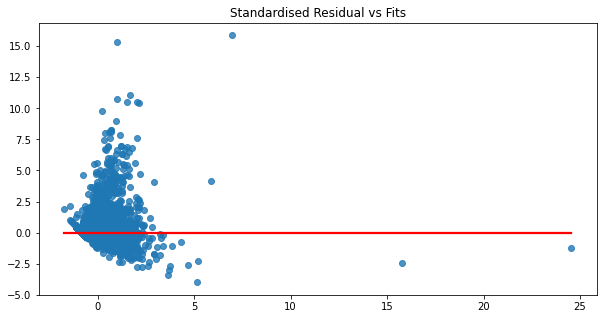

In [23]:
get_residual_plot(ols_base)

The residual plot indicates that the dependent variable is skewed.

### Baseline discussion
Two main problems identified were the presence of many redundant features, which could be due to multicollinearity as detected in the EDA and the skewness of the dependent variable.
<br>
<br>
I will thus try to address these issues to improve model performance.

## Feature selection 
2 different feature selection methods will be used, stepwise backwards regression using absolute t-value to procedurally eliminate featurues, as well as through sklearn's RFECV.

### Feature selection with stepwise backwards regression 

In [24]:
# Since dummy variables cannot be dropped one at a time, I preliminarily eliminated DistributionChannel
# as I determined it to not be important during the EDA
X_train_fs = X_train_scaled.drop(columns=X_train_scaled.columns[X_train_scaled.columns.str.contains("DistributionChannel")])
ols_fs = get_ols(X_train_fs, y_train_scaled)
print(ols_fs.summary())

                            OLS Regression Results                            
Dep. Variable:           TotalRevenue   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     371.3
Date:                Thu, 24 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:36:24   Log-Likelihood:                -6662.7
No. Observations:                7000   AIC:                         1.339e+04
Df Residuals:                    6970   BIC:                         1.359e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [25]:
# MarketSegment dummy variables are not in consideration to be dropped as 
# they cannot be eliminated one at at ime
market_segment_columns = list(X_train_fs.columns[X_train_fs.columns.str.contains("MarketSegment")])
variables_to_drop =  list(X_train_fs.columns[~X_train_fs.columns.str.contains("MarketSegment")])
variables_to_drop = [variable for variable in variables_to_drop if variable != "AgeMissing"]

variables_dropped = list(X_train_scaled.columns[X_train_scaled.columns.str.contains("DistributionChannel")])

best_score = 0
best_combination = []

for variable in variables_to_drop:
    print(variable)
    variables_left = [variable for variable in variables_to_drop if variable not in variables_dropped]
    variable_to_drop = ols_fs.tvalues[variables_left].abs().idxmin()
    
    
    variables_dropped.append(variable_to_drop)
    if variable_to_drop == "Age":
        variable_to_drop = "Age (and AgeMissing)"
        variables_dropped.append("AgeMissing")
                
    print("Variable dropped: ", variable_to_drop)
    cv_score = get_cv_score(X_train_scaled.drop(columns=variables_dropped), y_train_scaled)
    print("CV score: ", cv_score)
    
    if cv_score > best_score:
        best_score = cv_score
        best_combination = variables_left + market_segment_columns
        best_combination.remove(variable_to_drop)
        if "Age" in best_combination:
            best_combination.append("AgeMissing")
        
print()
print("Best score: ", best_score)
print("Best combination: ", best_combination)

    

Age
Variable dropped:  SRNearElevator
CV score:  0.5881454294105749
DaysSinceCreation
Variable dropped:  SRMediumFloor
CV score:  0.5881955052061043
AverageLeadTime
Variable dropped:  SRNoAlcoholInMiniBar
CV score:  0.5881955052061042
BookingsCanceled
Variable dropped:  SRAwayFromElevator
CV score:  0.5882190400601267
BookingsNoShowed
Variable dropped:  SRAccessibleRoom
CV score:  0.5882648264674061
BookingsCheckedIn
Variable dropped:  SRHighFloor
CV score:  0.5883425922316877
PersonsNights
Variable dropped:  SRShower
CV score:  0.5882764457974232
RoomNights
Variable dropped:  SRBathtub
CV score:  0.5884135271092719
DaysSinceLastStay
Variable dropped:  SRCrib
CV score:  0.5883107763475252
DaysSinceFirstStay
Variable dropped:  SRTwinBed
CV score:  0.5885563124730424
SRHighFloor
Variable dropped:  SRLowFloor
CV score:  0.5885218844120466
SRLowFloor
Variable dropped:  DaysSinceCreation
CV score:  0.5877163238687917
SRAccessibleRoom
Variable dropped:  DaysSinceFirstStay
CV score:  0.590760

In [26]:
ols_fs2 = get_ols(X_train_scaled[best_combination], y_train_scaled)
print(ols_fs2.summary())

                            OLS Regression Results                            
Dep. Variable:           TotalRevenue   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     672.7
Date:                Thu, 24 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:36:25   Log-Likelihood:                -6667.8
No. Observations:                7000   AIC:                         1.337e+04
Df Residuals:                    6983   BIC:                         1.349e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [27]:
print("Mean 5-fold cross validation R2: ", get_cv_score(X_train_scaled[best_combination], y_train_scaled))

Mean 5-fold cross validation R2:  0.596559141219592


In [28]:
# Out of sample
y_pred_fs = ols_fs2.predict(sm.add_constant(X_test_scaled[best_combination]))

print("OOS R2 Score: ", r2_score(y_test_scaled, y_pred_fs))

OOS R2 Score:  0.48199016856086574


Overall, model performance is slightly better, with mean CV score being slightly higher at 0.597 as compared to the base model's 0.588. However, this model is significantly more parsimonious, having only 10 features as compared to the base model's 27 features. 
<br>
<br>
The most important feature seems to be RoomNights.

### Feature selection with RFECV

In [29]:
# Though duummy variables shouldn't be dropped separately,
# RFECV does not allow for grouping of dummy variables
# Hence, I ran RFECV on all features, hoping to get some insights on which features are important
selector = RFECV(LinearRegression())

selector.fit(X_train_scaled, y_train_scaled)

pd.Series(selector.estimator_.coef_, index=selector.feature_names_in_[selector.support_])

PersonsNights                                  0.253939
RoomNights                                     0.543150
SRLowFloor                                    -0.198794
SRAccessibleRoom                               0.135924
SRBathtub                                     -0.094402
SRShower                                      -0.096638
MarketSegment_Complementary                   -0.397205
MarketSegment_Corporate                        0.189988
MarketSegment_Direct                           0.363011
MarketSegment_Groups                           0.199437
MarketSegment_Other                            0.262300
DistributionChannel_Electronic Distribution    0.145721
dtype: float64

In [30]:
print("Best CV Score: ", selector.cv_results_["mean_test_score"].max())

Best CV Score:  0.5923836717225571


The set of features produced by RFECV had a better mean CV score of 0.592 as compared to the base model as well. However, the set of features from stepwise backwards regression still yielded a model which performed better.
<br>
<br>
RFECV removed all but one level for DistributionChannel, indicating that DistributionChannel is unlikely to be important in predicting TotalRevenue and supporting my decision to not include it in my previous model.
<br>
<br>
The most important feature according to RFECV is RoomNights instead of PersonsNights. However, as noted above, the two are highly correlated and hence are likely to provide the same amount of information.

## Feature Selection Discussion
Both feature selection methods yielded slightly better CV scores to the base method, with the stepwise backwards regression performing best. Both yielded models with significantly less features, allowing for greater parsimony.
<br>
<br>
Both models indicate that the most important predictors of TotalRevenue are RoomNights and PersonNights. Since these are highly correlated, we can choose one to be the main predictor for greater simplicity.
<br>
<br>
Both models also suggest that Distribution Channel is not an important predictor of TotalRevenue.

# Transformations
Residual plot indicates skewness in the target variable. Hence, I will try using log of y+1 in order to reduce skewness. Log y+1 is used as TotalRevenue contains 0, which would return -infinity if log(y) was used.

In [31]:
y_train_log = np.log(y_train + 1).rename("TotalRevenue_log")
y_train_log_scaled = (y_train_log - y_train_log.mean()) / y_train_log.std()

In [32]:
ols_trans = get_ols(X_train_scaled, y_train_log_scaled)
print(ols_trans.summary())

                            OLS Regression Results                            
Dep. Variable:       TotalRevenue_log   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     791.1
Date:                Thu, 24 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:36:26   Log-Likelihood:                -4565.6
No. Observations:                7000   AIC:                             9197.
Df Residuals:                    6967   BIC:                             9423.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [33]:
print("Mean CV score: ", get_cv_score(X_train_scaled, y_train_log_scaled))

Mean CV score:  -0.8648227402879953


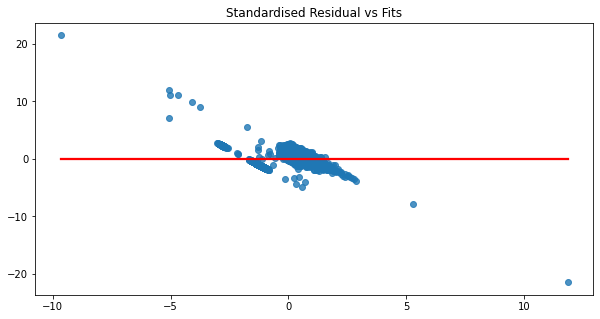

In [34]:
get_residual_plot(ols_trans)

In [35]:
back_transformed = np.exp((ols_trans.fittedvalues * y_train_log.std()) + y_train_log.mean()) - 1
print("OOS R2 score of back-transformed y: ", r2_score(y_train, back_transformed))

OOS R2 score of back-transformed y:  -2.9924488059566807e+21


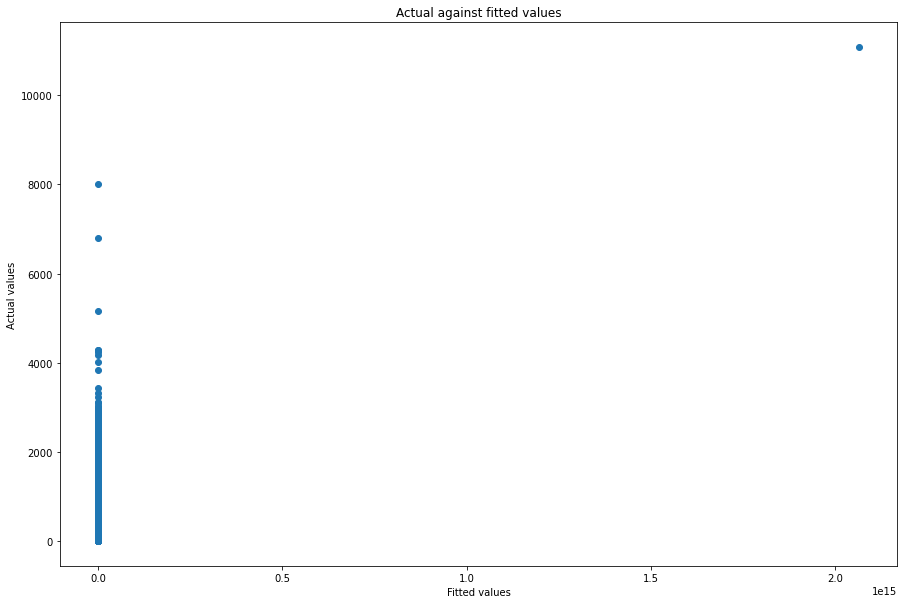

In [36]:
plt.figure(figsize=(15, 10))
plt.title("Actual against fitted values")
plt.scatter(back_transformed, y_train)
plt.xlabel("Fitted values")
plt.ylabel("Actual values")
plt.show()

## Transformation Discussion
Initially, log transforming the target variable yielded a better adjusted R2. However, the mean cross validation score was extremely poor and significantly worse than the baseline of 0. This indicates high variance.
<br>
<br>
Moreover, the residual plot showed a clear downward trend, violating the assumption of heteroskedasticity. 
<br>
<br>
The R2 score of the back-transformed dependent variable is also extremely bad, likely due to the presence of one observation with an extremely large residual (as observed in the top right corner of the actual vs fitted values plot).
<br>
<br>
As such, the log-transformation is not used to model TotalRevenue and its coefficients are not discussed.

# Model 2 - Two-Step Model
Since a large number of values in TotalRevenue are 0, it might be useful to model it by first predicting whether TotalRevenue will be 0 before predicting the value if it is not 0.
<br>
<ol>
    <li> Use logistic regression to predict if TotalRevenue is 0 or not 0.
    <li> If TotalRevenue is not 0, use OLS to predict TotalRevenue.

In [37]:
# Logistic Regression
# Use features selected from the previous model to prevent multicollinearity,
# as the presence of highly correlated/perfectly correlated features may lead to singular matrix error
y_train_logreg = np.array([1 if y == 0 else 0 for y in y_train])

logreg = sm.Logit(y_train_logreg, sm.add_constant(X_train_scaled[best_combination])).fit(method="bfgs", maxiter=300)
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.008573
         Iterations: 198
         Function evaluations: 200
         Gradient evaluations: 200
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6983
Method:                           MLE   Df Model:                           16
Date:                Thu, 24 Mar 2022   Pseudo R-squ.:                  0.9844
Time:                        22:36:27   Log-Likelihood:                -60.009
converged:                       True   LL-Null:                       -3846.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [38]:
# To evaluate the logistic regression, we use mean RMSE of a 5-fold cross validation
# High value of RMSE indicates that many 0s are predicted as 1s or vice-versa
logreg_cv = LogisticRegression()
logreg_cv_scores = cross_val_score(logreg_cv, X_train_scaled[best_combination], y_train_logreg, scoring="neg_root_mean_squared_error")
print("Mean RMSE: ", -logreg_cv_scores.mean())

Mean RMSE:  0.04060101354856657


In [39]:
# Linear regression on non-0 values
X_train_2part = X_train_scaled[best_combination].copy()
X_train_2part = X_train_2part[y_train > 0]

y_train_2part = y_train[y_train > 0].copy()

# scale
y_train_2part_scaled = (y_train_2part - y_train_2part.mean()) / y_train_2part.std()

ols_2part = get_ols(X_train_2part, y_train_2part_scaled)
print(ols_2part.summary())

                            OLS Regression Results                            
Dep. Variable:           TotalRevenue   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     348.5
Date:                Thu, 24 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:36:27   Log-Likelihood:                -5649.9
No. Observations:                5330   AIC:                         1.133e+04
Df Residuals:                    5313   BIC:                         1.145e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [40]:
print("Mean CV score: ", get_cv_score(X_train_2part, y_train_2part_scaled))

Mean CV score:  0.49854769719580416


In [41]:
# Calculate in sample R2
preds_is = logreg.predict(sm.add_constant(X_train_scaled[best_combination]))

# Use threshold of 0.5
preds_class_is = np.array([1 if pred > 0.5 else 0 for pred in preds_is])

# preds_class == 0 indicates that predicted TotalRevenue is not 0,
# Value should be predicted using the linear regression
y_pred_2part_is = ols_2part.predict(sm.add_constant(X_train_scaled[best_combination][preds_class_is == 0]))

# Unscale
y_pred_2part_unscaled_is = (y_pred_2part_is * y_train_2part.std()) + y_train_2part.mean()

# Get the full set of predicted values
y_pred_2part_is_full = []
idx = 0

for pred_class in preds_class_is:
    if pred_class == 1: # Predicted that TotalRevenue is 0
        y_pred_2part_is_full.append(0)
    else:
        # Add in the corresponding predicted value of TotalRevenue
        y_pred_2part_is_full.append(y_pred_2part_unscaled_is.iloc[idx])
        idx += 1


# Calculate R2
print("In sample R2: ", r2_score(y_train, y_pred_2part_is_full))

In sample R2:  0.6127093494215801


The within sample R2 performs better than the best version of model 1, which has an R2 score of 0.606.

In [42]:
# Calculate OOS R2
preds_oos = logreg.predict(sm.add_constant(X_test_scaled[best_combination]))

# Use threshold of 0.5
preds_class_oos = np.array([1 if pred > 0.5 else 0 for pred in preds_oos])

# preds_class == 0 indicates that predicted TotalRevenue is not 0,
# Value should be predicted using the linear regression
y_pred_2part_oos = ols_2part.predict(sm.add_constant(X_test_scaled[best_combination][preds_class_oos == 0]))

# Unscale
y_pred_2part_unscaled_oos = (y_pred_2part_oos * y_train_2part.std()) + y_train_2part.mean()

# Get the full set of predicted values
y_pred_2part_oos_full = []
idx = 0

for pred_class in preds_class_oos:
    if pred_class == 1: # Predicted that TotalRevenue is 0
        y_pred_2part_oos_full.append(0)
    else:
        # Add in the corresponding predicted value of TotalRevenue
        y_pred_2part_oos_full.append(y_pred_2part_unscaled_oos.iloc[idx])
        idx += 1


# Calculate R2
print("OOS R2: ", r2_score(y_test, y_pred_2part_oos_full))

OOS R2:  0.48619176363921934


The out of sample R2 also performs slightly better than the best version of model 1, which has an OOS R2 of 0.482.

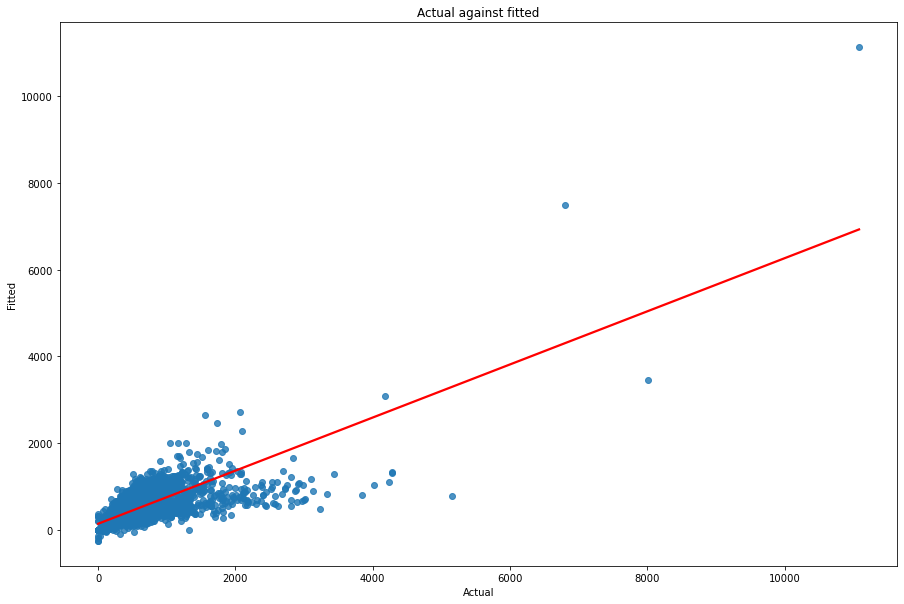

In [43]:
plt.figure(figsize=(15,10))
sns.regplot(y_train, y_pred_2part_is_full, ci=False, line_kws={"color": "red"})
#plt.scatter(y_train, y_pred_2part_is_full)
plt.title("Actual against fitted")
plt.xlabel("Actual")
plt.ylabel("Fitted")
plt.show()

This model outperforms the best version of model 1 in terms of both in-sample and out-of-sample R2. The plot of actual against fitted values also seems to generally show that fitted values and actual values tend to move in the same direction, indicating a reasonable fit.
<br>


# Model 3 -  L1 Regularization
L1 regularized regression was also attempted to improve prediction accuuracy and model simplicity. GridSearchCV is used to determine the value of the penalty.
<br>
<br>
L1 was preferred to L2 and L3 regularization as the EDA and previous models had indicated that there were large number of redundant features, and hence I wanted to remove those redundant features.

In [44]:
# First pass
l1 = Lasso()

params = {
    "alpha": [0.01, 0.1, 1, 10, 100]
}
gs = GridSearchCV(l1, params)
gs.fit(X_train_scaled, y_train_scaled)

print(gs.best_params_)

{'alpha': 0.01}


In [45]:
# Second pass with a narrower grid to find a better value of alpha
params = {
    "alpha": np.arange(0.001, 0.02, 0.001)
}
gs = GridSearchCV(l1, params)
gs.fit(X_train_scaled, y_train_scaled)

print(gs.best_params_)

{'alpha': 0.004}


In [46]:
print("Best CV score: ", gs.best_score_)

Best CV score:  0.5961925280603261


In [47]:
l1_coefs = pd.Series(gs.best_estimator_.coef_, index=X_train_scaled.columns)
print("Discarded features: ")
print()
print(l1_coefs[l1_coefs == 0])
print()

order = l1_coefs[l1_coefs != 0].abs().sort_values(ascending=False).index
print("Kept features (Decreasing importance): ")
print()
print(l1_coefs[order])

Discarded features: 

DaysSinceFirstStay                            -0.0
SRHighFloor                                    0.0
SRLowFloor                                    -0.0
SRAccessibleRoom                               0.0
SRMediumFloor                                 -0.0
SRBathtub                                     -0.0
SRShower                                      -0.0
SRCrib                                        -0.0
SRTwinBed                                      0.0
SRNearElevator                                 0.0
SRAwayFromElevator                            -0.0
SRNoAlcoholInMiniBar                           0.0
MarketSegment_Complementary                   -0.0
MarketSegment_Corporate                       -0.0
MarketSegment_Groups                          -0.0
DistributionChannel_Direct                     0.0
DistributionChannel_Electronic Distribution    0.0
DistributionChannel_Travel Agent/Operator     -0.0
AgeMissing                                    -0.0
dtype: fl

In [48]:
y_pred = gs.predict(X_test_scaled)

print("OOS R2 Score: ", r2_score(y_test_scaled, y_pred))

OOS R2 Score:  0.4813550670637764


The model produced is similar to the best version of model 1 in terms of the features kept and discarded. Similarly, this model also ranks RoomNights as being the most important feature in determining TotalRevenue. This models' mean CV score of 0.596 is also similar to that of the best version of model 1.

# Overall discussion
In summary, I attempted three approaches to modeling TotalRevenue:
<ol>
    <li> An OLS-based model
    <li> A 2-part model involving both logistic regression and linear regression
    <li> An L1 regularized model
</ol>
<br>
All three models performed similarly in terms of R2 score. However, model 2 slightly outperformed the others. 
<br>
<br>
All three models seemed to indicate that either PersonsNights or RoomNights are the most important predictors of TotalRevenue. 
<br>
<br>
Additionally, models 1 and 3 also indicated that DistributionChannel and most special requests are not important in determining TotalRevenue.
<br>
<br>
Models also indicated that market segment may be a good predictor of TotalRevenue. Namely, customers from the "complemntary" market segment would tend to yield lower total revenues, which makes intuitive sense as belonging to the "complementary" market segment indicates one would stay for free.
<br>
<br>
On the other hand, customers from the "Direct" market segment tend to spend a greater amount of money. 

# Appendix

In [49]:
# Unscaling the betas for easier interpretability
# Based on: 
# https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables

unscaled_betas = []

sy = y_train.std()

for feature in ols_fs2.params.drop(["const", "AgeMissing"]).index:
    beta = ols_fs2.params[feature]
    sj = X_train[feature].std()
    Xj_bar = X_train[feature].mean()
    
    if "MarketSegment" in feature:
        unscaled_beta = beta * sy
        
    else:
        unscaled_beta = beta * sy / sj
    
    unscaled_betas.append(unscaled_beta)
    
pd.Series(unscaled_betas, index=ols_fs2.params.drop(["const", "AgeMissing"]).index)

Age                                     -0.512707
AverageLeadTime                          0.122800
BookingsCanceled                      -679.492500
BookingsCheckedIn                       33.179524
PersonsNights                           25.200758
RoomNights                             101.332571
DaysSinceLastStay                       -0.081677
SRKingSizeBed                          -57.256067
SRQuietRoom                             97.264893
MarketSegment_Complementary           -165.908942
MarketSegment_Corporate                 87.472145
MarketSegment_Direct                   159.181207
MarketSegment_Groups                    87.427184
MarketSegment_Other                    120.674267
MarketSegment_Travel Agent/Operator     -3.997239
dtype: float64